In [1]:
import os
import math
import time
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import sklearn.ensemble as ske
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,f1_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
def sensor_emotion_signal(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    if ymap != None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)


In [3]:
data = pd.read_csv('./EEG-Brainwave-Sensor-Dataset/EEG dataset.csv', sep=',')

In [4]:
data.head(10)

,Id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F77,F78,F79,F80,F81,F82,F83,F84,F85,Class
0,1,1.000000,0.760188,0.760727,1.000000,1.000000,0.619948,0.760190,0.619946,0.760204,...,0.760201,0.760300,1.000000,0.620375,5.7974,5.7923,5.7573,11.9891,11.9565,0
1,2,0.760193,0.760200,1.000000,0.760203,0.760206,0.760194,0.760198,1.000000,0.760197,...,0.760219,0.760310,0.760312,0.760298,0.3977,0.3955,0.3550,0.1240,0.1160,0
2,3,0.760190,1.000000,1.000000,0.760193,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.760275,1.000000,33.0799,32.8870,32.8870,26.5851,26.6158,0
3,4,0.760194,0.760202,1.000000,0.760188,0.760199,0.760200,0.760201,0.620025,0.760199,...,0.760261,1.000000,0.760253,1.000000,4.3899,4.4189,4.4297,5.0397,5.0380,0
4,5,1.000000,0.760193,0.619927,1.000000,1.000000,1.000000,0.760205,0.619962,1.000000,...,1.000000,1.000000,0.760188,0.760211,9.6461,9.6837,9.6429,17.3712,17.3036,0
5,6,1.000000,0.760196,0.760193,1.000000,0.760194,0.619928,0.760195,1.000000,0.760283,...,1.000000,0.760288,0.760201,1.000000,10.4345,10.4730,10.4956,14.4285,14.3872,0
6,7,0.760201,1.000000,1.000000,0.760196,1.000000,1.000000,0.620043,0.760199,0.760197,...,1.000000,1.000000,0.760375,0.760281,17.4661,17.3828,17.3603,17.0539,17.0178,1
7,8,0.760188,1.000000,0.760197,1.000000,0.760240,0.760204,1.000000,0.760191,1.000000,...,0.760215,0.760251,0.760243,1.000000,1.4659,1.4656,1.4551,3.1149,3.0895,2
8,9,0.760239,1.000000,0.760189,1.000000,0.760243,1.000000,1.000000,0.760188,0.619972,...,0.760345,0.760352,0.760210,1.000000,11.7676,11.6987,11.6746,8.6417,8.6038,3
9,10,0.760195,0.760197,1.000000,1.000000,1.000000,0.760196,0.760193,0.619940,0.760194,...,0.760246,1.000000,0.619913,0.760264,4.4405,4.5691,4.5075,17.9738,18.0021,1


In [5]:
rows_count, columns_count = data.shape
print('Total Number of rows :', rows_count)
print('Total Number of columns :', columns_count)

Total Number of rows : 216
Total Number of columns : 87


In [6]:
data.dtypes

Id         int64
F1       float64
F2       float64
F3       float64
F4       float64
          ...   
F82      float64
F83      float64
F84      float64
F85      float64
Class      int64
Length: 87, dtype: object

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      216 non-null    int64  
 1   F1      216 non-null    float64
 2   F2      216 non-null    float64
 3   F3      216 non-null    float64
 4   F4      216 non-null    float64
 5   F5      216 non-null    float64
 6   F6      216 non-null    float64
 7   F7      216 non-null    float64
 8   F8      216 non-null    float64
 9   F9      216 non-null    float64
 10  F10     216 non-null    float64
 11  F11     216 non-null    float64
 12  F12     216 non-null    float64
 13  F13     216 non-null    float64
 14  F14     216 non-null    float64
 15  F15     216 non-null    float64
 16  F16     216 non-null    float64
 17  F17     216 non-null    float64
 18  F18     216 non-null    float64
 19  F19     216 non-null    float64
 20  F20     216 non-null    float64
 21  F21     216 non-null    float64
 22  F2

In [8]:
data.isnull().sum() 

Id       0
F1       0
F2       0
F3       0
F4       0
        ..
F82      0
F83      0
F84      0
F85      0
Class    0
Length: 87, dtype: int64

In [9]:
#percentage of missing values for each column:
data.isna().sum()/len(data)*100

Id       0.0
F1       0.0
F2       0.0
F3       0.0
F4       0.0
        ... 
F82      0.0
F83      0.0
F84      0.0
F85      0.0
Class    0.0
Length: 87, dtype: float64

In [10]:
def missing_values_table(df):
        #Total missing values
        mis_val = df.isnull().sum()
        
        #Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        #Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        #Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        #Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        #Print some summary information
        print ("selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        #Return the dataframe with missing information
        return mis_val_table_ren_columns


In [11]:
train_missing= missing_values_table(data)
train_missing

selected dataframe has 87 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


<AxesSubplot:>

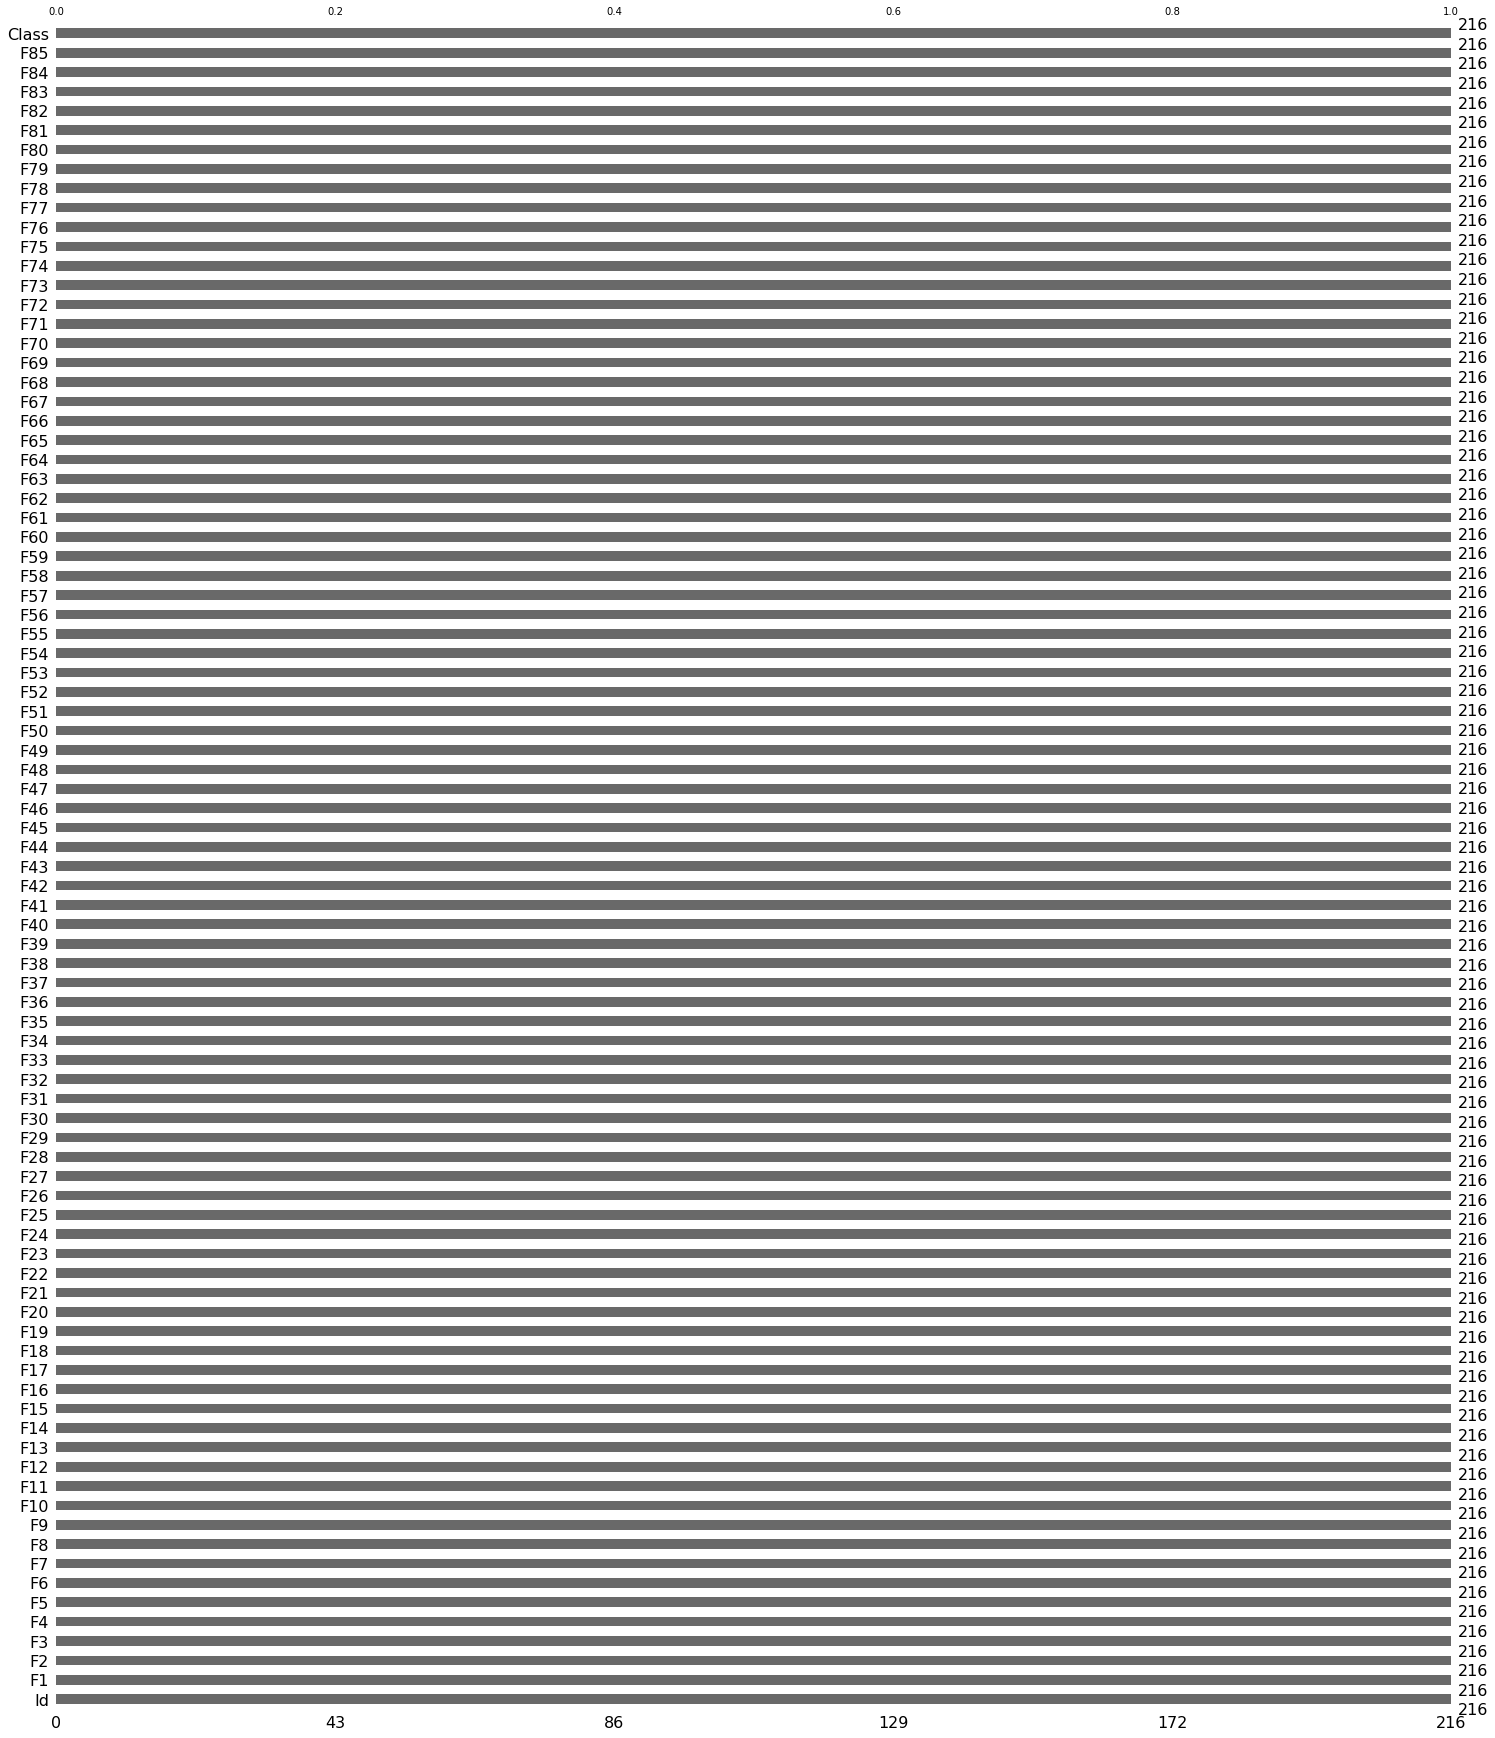

In [12]:
msno.bar(data)

In [13]:
data.isna().sum()/len(data)*100

Id       0.0
F1       0.0
F2       0.0
F3       0.0
F4       0.0
        ... 
F82      0.0
F83      0.0
F84      0.0
F85      0.0
Class    0.0
Length: 87, dtype: float64

In [14]:
data.isnull().values.any()

False

In [15]:
data.nunique()

Id       216
F1        53
F2        46
F3        55
F4        51
        ... 
F82       71
F83       70
F84       70
F85       71
Class      4
Length: 87, dtype: int64

In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,216.0,108.500000,62.498000,1.000000,54.750000,108.500000,162.250000,216.0000
F1,216.0,0.908717,0.126116,0.538982,0.760353,0.982318,0.999642,1.0000
F2,216.0,0.944017,0.088212,0.760188,0.954593,0.983509,1.000000,1.0000
F3,216.0,0.903723,0.125809,0.529879,0.760202,0.973253,0.993623,1.0000
F4,216.0,0.914969,0.109046,0.619928,0.760233,0.979048,1.000000,1.0000
...,...,...,...,...,...,...,...,...
F82,216.0,11.123151,9.758837,0.222500,4.092075,8.549600,15.726175,41.3294
F83,216.0,10.573385,10.884070,0.268200,3.161725,7.589550,13.281175,55.8929
F84,216.0,13.118581,10.574458,0.124000,5.406975,10.610050,17.133225,52.5579
F85,216.0,12.936408,9.503308,0.116000,4.986800,11.672150,17.319675,37.1651


In [17]:
data_transpose = data.describe().T
data_transpose[['min', '25%', '50%', '75%', 'max']]

,min,25%,50%,75%,max
Id,1.000000,54.750000,108.500000,162.250000,216.0000
F1,0.538982,0.760353,0.982318,0.999642,1.0000
F2,0.760188,0.954593,0.983509,1.000000,1.0000
F3,0.529879,0.760202,0.973253,0.993623,1.0000
F4,0.619928,0.760233,0.979048,1.000000,1.0000
...,...,...,...,...,...
F82,0.222500,4.092075,8.549600,15.726175,41.3294
F83,0.268200,3.161725,7.589550,13.281175,55.8929
F84,0.124000,5.406975,10.610050,17.133225,52.5579
F85,0.116000,4.986800,11.672150,17.319675,37.1651


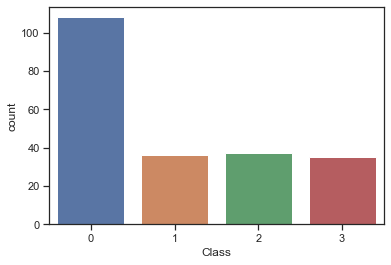

In [18]:
sns.set(style="ticks")
f = sns.countplot(x="Class", data=data)
plt.show()

In [19]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [20]:
X = data.drop(columns=['Class'])
y = data['Class']

scaler = StandardScaler()
X = scaler.fit_transform(X)

enc = LabelEncoder()
y = enc.fit_transform(y)


216
Feature: 0, Score: 0.00267,Rank: 18.000
Feature: 1, Score: 0.00304,Rank: 25.000
Feature: 2, Score: 0.00288,Rank: 6.000
Feature: 3, Score: 0.00373,Rank: 56.000
Feature: 4, Score: 0.00237,Rank: 1.000
Feature: 5, Score: 0.00296,Rank: 1.000
Feature: 6, Score: 0.00290,Rank: 85.000
Feature: 7, Score: 0.02868,Rank: 1.000
Feature: 8, Score: 0.00309,Rank: 1.000
Feature: 9, Score: 0.00357,Rank: 1.000
Feature: 10, Score: 0.00301,Rank: 1.000
Feature: 11, Score: 0.00186,Rank: 44.000
Feature: 12, Score: 0.00206,Rank: 88.000
Feature: 13, Score: 0.00220,Rank: 79.000
Feature: 14, Score: 0.00268,Rank: 1.000
Feature: 15, Score: 0.00407,Rank: 1.000
Feature: 16, Score: 0.04541,Rank: 1.000
Feature: 17, Score: 0.00290,Rank: 1.000
Feature: 18, Score: 0.00244,Rank: 50.000
Feature: 19, Score: 0.00196,Rank: 72.000
Feature: 20, Score: 0.00258,Rank: 54.000
Feature: 21, Score: 0.00277,Rank: 109.000
Feature: 22, Score: 0.00309,Rank: 1.000
Feature: 23, Score: 0.00974,Rank: 1.000
Feature: 24, Score: 0.00281,Rank: 

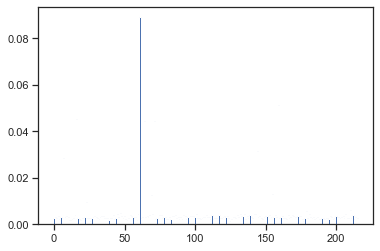

In [21]:

# random forest for feature importance on a regression problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=len(X), n_informative=5, n_redundant=5, random_state=1)
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
dimp={}
rfe = RFE(estimator=RandomForestClassifier())
# fit RFE
rfe.fit(X, y)
index_list=[]
print(len(importance))
for i,v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f,Rank: %.3f' % (i,rfe.support_[i], rfe.ranking_[i]))
    print('Feature: %0d, Score: %.5f,Rank: %.3f' % (i,v, rfe.ranking_[i]))
    if rfe.ranking_[i]==1:
        index_list.append(i)
    dimp[i]=v
    
# summarize feature importance
#for i,v in enumerate(importance):
	#print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [22]:
len(index_list)

108

In [24]:
l=data.columns

In [25]:
l=l.tolist()

In [26]:
l=l[1:]

In [27]:
l

['F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12',
 'F13',
 'F14',
 'F15',
 'F16',
 'F17',
 'F18',
 'F19',
 'F20',
 'F21',
 'F22',
 'F23',
 'F24',
 'F25',
 'F26',
 'F27',
 'F28',
 'F29',
 'F30',
 'F31',
 'F32',
 'F33',
 'F34',
 'F35',
 'F36',
 'F37',
 'F38',
 'F39',
 'F40',
 'F41',
 'F42',
 'F43',
 'F44',
 'F45',
 'F46',
 'F47',
 'F48',
 'F49',
 'F50',
 'F51',
 'F52',
 'F53',
 'F54',
 'F55',
 'F56',
 'F57',
 'F58',
 'F59',
 'F60',
 'F61',
 'F62',
 'F63',
 'F64',
 'F65',
 'F66',
 'F67',
 'F68',
 'F69',
 'F70',
 'F71',
 'F72',
 'F73',
 'F74',
 'F75',
 'F76',
 'F77',
 'F78',
 'F79',
 'F80',
 'F81',
 'F82',
 'F83',
 'F84',
 'F85',
 'Class']

In [28]:
selected_best_features=[]
for i in index_list:
    print(i)
    selected_best_features.append(l[i])

4
5
7
8
9
10
14
15
16
17
22
23
30
33
35
38
40
42
44
45
46
47
49
50
52
53
54
55
60
61
63
64
65
68
69
70
71
72
76
79
84
85
87


IndexError: list index out of range

In [29]:
len(selected_best_features)

42

In [31]:
df1=data[selected_best_features]

In [32]:
df1

,F5,F6,F8,F9,F10,F11,F15,F16,F17,F18,...,F66,F69,F70,F71,F72,F73,F77,F80,F85,Class
0,1.000000,0.619948,0.619946,0.760204,0.620021,0.760235,1.000000,1.000000,1.000000,0.760261,...,0.760608,0.760230,1.000000,0.760342,1.000000,0.760374,0.760201,0.620375,11.9565,0
1,0.760206,0.760194,1.000000,0.760197,1.000000,0.760200,0.760197,0.760198,0.760201,0.760219,...,0.760266,0.760316,0.760276,0.760270,0.760305,0.760261,0.760219,0.760298,0.1160,0
2,1.000000,1.000000,1.000000,1.000000,0.760192,1.000000,0.760211,1.000000,0.760188,1.000000,...,1.000000,1.000000,0.620498,1.000000,1.000000,0.620082,1.000000,1.000000,26.6158,0
3,0.760199,0.760200,0.620025,0.760199,0.760198,1.000000,0.760205,1.000000,0.760204,0.760221,...,0.760391,0.760230,0.760248,0.760188,1.000000,0.760339,0.760261,1.000000,5.0380,0
4,1.000000,1.000000,0.619962,1.000000,0.760207,1.000000,0.760189,0.760198,1.000000,0.760219,...,0.760250,1.000000,1.000000,0.760206,1.000000,1.000000,1.000000,0.760211,17.3036,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.974798,0.989429,0.997414,0.980088,0.967636,0.989474,0.954334,0.979518,0.999808,1.000000,...,0.992472,0.998453,0.969807,0.985949,0.908291,0.996598,0.991694,0.973607,37.1651,2
212,0.982399,0.992096,0.975254,0.980730,0.988166,0.969514,0.994330,0.979078,0.999481,0.958383,...,0.990187,0.995683,0.955896,0.990777,0.996354,0.996871,0.995139,1.000000,35.2057,3
213,0.965775,0.945798,0.967879,0.986044,0.952342,0.974805,0.976488,0.982793,0.988903,0.997883,...,0.990877,0.988706,0.973494,0.994292,0.982986,0.985584,0.991904,0.998529,4.4981,1
214,0.973622,0.980828,0.970921,0.994212,0.979211,0.981760,1.000000,0.969855,0.996295,0.968717,...,0.978795,0.992633,0.991190,0.970301,0.977083,0.972928,0.991062,0.972931,1.1825,2


In [33]:
df1.to_csv('final_data_eegsleep.csv')

In [ ]:
sel_rf=SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=1))

sel_rf.fit(X_train, y_train)

In [ ]:
print("Total number of features in the database: ", len(X_train.columns))
print("Total number of features after removing according to RF feature importances: ", sel_rf.get_support().sum())
print("Total features removed: ", int(len(X_train.columns)-sel_rf.get_support().sum()))

In [ ]:
# Let's check the shape of the data now to confirm that they have 16 features now
X_train_rfc.shape, X_test_rfc.shape

In [ ]:
# X = data.drop('Label', axis=1)
# y = data['Label']

In [ ]:
X

In [ ]:
y

In [ ]:
from sklearn import svm

In [ ]:
print('Testing  key  feature:')
fsel = ske.ExtraTreesClassifier().fit(X, y)
model = SelectFromModel(fsel, prefit=True)
X_new = model.transform(X)
nb_features = X_new.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.3)
features = []
indices = np.argsort(fsel.feature_importances_)[::-1][:nb_features]
a =np.argsort(fsel.feature_importances_)[::-1][:nb_features]
for f in sorted(np.argsort(fsel.feature_importances_)[::-1][:nb_features]):
    features.append(data.columns[f])

'''
Train Models:
(alg1=Random Forest, alg2=AdaBoost, alg3=Gausian Naive Bayes, alg4=MLP, alg5=Decision Tree, alg6=Support Vector Machine, 
alg7=Logistic Reggression)

'''   
algorithms = {
        "RF": ske.RandomForestClassifier(n_estimators=50),
        "AB": ske.AdaBoostClassifier(n_estimators=100),
        "GNB": GaussianNB(),
        "MLP": MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1),
        "DT": DecisionTreeClassifier(),
        #"SVM": SVC(kernel='rbf'),
        "SVM":svm.LinearSVC(),
        "LR": LogisticRegression()
    }

results = {}
print("Algorithm Test:")
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score
D=results
plt.figure();
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
bestAlgo = max(results, key=results.get)
print('\nBest algorithm is %s with a %f %% success' % (bestAlgo, results[bestAlgo]*100))
clf = algorithms[bestAlgo]
res = clf.predict(X_test)
mt = confusion_matrix(y_test, res)
sensor_emotion_signal(y_test, res,clf.classes_)
FS=f1_score(y_test, res, average='macro')
plt.show()
print ('F1 Score is  : %f %%'% (FS*100))
print ('Confusion Matrix')
print (mt)
print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
print('False negative rate : %f %%' % ( (mt[1][0] / float(sum(mt[1]))*100)))

winner = max(results, key=results.get)
print('\nWinner algorithm is %s with a %f %% success' % (winner, results[winner]*100))
clf = algorithms[winner]
res = clf.predict(X_test)
mt = confusion_matrix(y_test, res)
print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
print('False negative rate : %f %%' % ( (mt[1][0] / float(sum(mt[1]))*100)))

In [ ]:
joblib.dump(clf,'Best_Model.pkl')